# Process AZFP echosounder data using externally stored glider data

Jupyter notebook accompanying the manuscript:

_Echopype: Interoperable and scalable echosounder data processing with Echopype_  
_Authors: Wu-Jung Lee, Landung Setiawan, Caesar Tuguinay, Emilio Mayorga, and Valentina Staneva_

## Introduction

### Goals

- Demonstrate the processing of ASL Environmental Sciences AZFP echosounder files.
- Update platform location data in an echosounder converted dataset using data from an external file.
- Use environmental data from an external file to calibrate the backscatter data.
- Use motion data from an external file to assign depth to the calibrated backscatter data.
- Demonstrate the seamless integration of Echopype data products with an external open-source Fisheries Acoustics package for advanced processing capabilities.

### Description

When an echosounder raw data file does not contain location (latitude and longitude) and environmental (temperature, salinity and pressure) data, `echopype` can be used to integrate such data from external sources. This notebook illustrates these steps using data provided by personnel from the [Department of Marine and Coastal Sciences at Rutgers University](https://marine.rutgers.edu/). The data was collected by a Slocum glider deployed in the Southern Ocean off Antarctica (Ross Sea) in 2018 and fitted with an [Acoustic Zooplankton and Fisher Profiler (AZFP)](https://aslenv.com/azfp.html) echosounder from ASL Environmental Sciences. The data used here are from a single dive and span approximately 15 minutes. We thank [Delphine Mossman](https://rucool.marine.rutgers.edu/people/delphine-mossman/) for providing these data files and background information.

In this notebook we attempt to correct for the orientation of the glider to correctly interpret the echosounder data and identify Zooplankton swarms. Such steps are discussed in further detail in the [2021 M.S. thesis from Ailey Sheehan](https://rucool.marine.rutgers.edu/wp-content/uploads/2022/06/Ailey_Thesis_FinalDraft.pdf), another member of the same Rutgers team. The computations are available in the associated GitHub repository, https://github.com/a-sheehan/Echopype-Processing-Pipeline-for-AZFP-and-Glider-Data.

### Running the notebook

This notebook can be run with a [conda](https://docs.conda.io) environment created using the [instructions in the accompanying GitHub repository README.md file.](https://github.com/OSOceanAcoustics/echopype-examples#run-the-notebooks-locally-on-your-machine). It uses data files found in the `notebooks/data` directory in this repository (https://github.com/OSOceanAcoustics/echopype-examples/).

In [54]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import xarray as xr
from scipy.spatial.transform import Rotation as R
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import echopype as ep
import echopype.colormap

import echopy.processing.mask_shoals

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Set path to example data:

In [2]:
data_dpath = Path('./example_data/Glider_AZFP')

## Open data files and convert the raw AZFP data

### Open and convert raw AZFP data

To open an AZFP data file (`*.01A` files), the accompanying `XML` metadata file must be provided.

In [3]:
azfp_data_fpath = data_dpath / "18011107.01A"

ed = ep.open_raw(
    azfp_data_fpath, 
    xml_path=data_dpath / "18011107.XML", 
    sonar_model="AZFP"
)

In [4]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

AZFP raw data files don't store latitude and longitude data. Therefore, the `Platform` group does not contain such data (or the variables).

In [5]:
"latitude" in ed["Platform"].data_vars, "longitude" in ed["Platform"].data_vars

(True, True)

As this echosounder is deployed on a glider that collects independent CTD data, the temperature sensor is disabled. The `temperature` variable is filled with `nan`.

In [6]:
ed["Environment"]

<xarray.Dataset> Size: 188B
Dimensions:                 (channel: 3)
Coordinates:
  * channel                 (channel) <U11 132B '59006-38-1' ... '59006-200-3'
Data variables:
    absorption_indicative   (channel) float64 24B nan nan nan
    sound_speed_indicative  float64 8B nan
    frequency_nominal       (channel) float64 24B 3.8e+04 1.25e+05 2e+05

### Open external glider data netCDF file

The glider data are available at http://slocum-data.marine.rutgers.edu/erddap/tabledap/ru32-20180109T0531-profile-sci-delayed.html. We previously downloaded, subset and pre-processed that dataset to make it easier to use in this example.

In [7]:
glider_nc_fpath = data_dpath / "ru32-20180109T0531-profile-sci-delayed-subset.nc"

In [8]:
glider_ds = xr.open_dataset(glider_nc_fpath)
glider_ds

<xarray.Dataset> Size: 454kB
Dimensions:                    (time: 915)
Coordinates:
  * time                       (time) datetime64[ns] 7kB 2018-01-11T07:26:20....
Data variables: (12/59)
    latitude                   (time) float64 7kB ...
    longitude                  (time) float64 7kB ...
    depth                      (time) float32 4kB ...
    trajectory                 (time) <U18 66kB ...
    source_file                (time) <U31 113kB ...
    beta_700nm                 (time) float32 4kB ...
    ...                         ...
    sci_water_pressure         (time) float32 4kB ...
    sound_speed                (time) float32 4kB ...
    temperature                (time) float32 4kB ...
    u                          (time) float32 4kB ...
    v                          (time) float32 4kB ...
    water_depth                (time) float32 4kB ...
Attributes: (12/72)
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Glider was deployed/recovered from the R...
    contributor_name:                Grace Saba, Dave Aragon, Chip Haldeman, ...
    contributor_role:                Principal Investigator, Glider Pilot, Gl...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    ...                              ...
    time_coverage_resolution:        PTS
    time_coverage_start:             2018-01-09T05:29:54Z
    title:                           ru32-20180109T0531 Delayed Science Profile
    uuid:                            82c40f91-87ab-40bb-a1ea-3f1c366a0378
    Westernmost_Easting:             164.36469500000004
    wmo_id:                          7801506

The external glider data time range encompasses that of the AZFP data. Let's compare the two time ranges:

In [9]:
glider_ds.time.min().values, glider_ds.time.max().values

(np.datetime64('2018-01-11T07:26:20.320559872'),
 np.datetime64('2018-01-11T08:00:28.788059904'))

In [10]:
ed["Sonar/Beam_group1"]["ping_time"].min().values, ed["Sonar/Beam_group1"]["ping_time"].max().values

(np.datetime64('2018-01-11T07:44:40.000000000'),
 np.datetime64('2018-01-11T07:59:59.000000000'))

## Update EchoData `Platform` group with glider data and metadata

### Update Platform and Top-level metadata

While not required for data processing, it's always a good idea to include as much metadata as possible. We'll take advantage of the metadata found in the glider netCDF file to populate some of this metadata.

In [11]:
# Manually populate additional metadata about the dataset and the platform
# -- SONAR-netCDF4 Top-level Group attributes
ed['Top-level'].attrs['title'] = "2018 Ross Sea Slocum glider AZFP echosounder data from Rutgers University"
ed['Top-level'].attrs['summary'] = glider_ds.attrs['summary']

# -- SONAR-netCDF4 Platform Group attributes
ed['Platform'].attrs['platform_type'] = glider_ds.attrs['platform_type']
ed['Platform'].attrs['platform_name'] = "Rutgers r32 Slocum Webb G2 glider"
ed['Platform'].attrs['platform_code_ICES'] = glider_ds.attrs['wmo_id']

Here are the updated attributes in the "Top-level" group:

In [12]:
ed['Top-level'].attrs

{'conventions': 'CF-1.7, SONAR-netCDF4-1.0, ACDD-1.3',
 'keywords': 'AZFP',
 'sonar_convention_authority': 'ICES',
 'sonar_convention_name': 'SONAR-netCDF4',
 'sonar_convention_version': '1.0',
 'summary': 'This project integrated an Acoustic Zooplankton and Fish Profiler (AZFP) multi-frequency echo sounder into a Slocum Webb G2 glider. The AZFP is complemented with existing glider sensors including a CTD, a WET Labs BB2FL ECO puck configured for simultaneous chlorophyll fluorescence (phytoplankton biomass) and optical backscatter measurements, and an Aanderaa Optode for measuring dissolved oxygen. This glider deployment is located in the polynya of Terra Nova Bay (western Ross Sea, Antarctica), and is focused on investigating relationships between phytoplankton-zooplankton-fish distributions and the physical drivers of zooplankton and silverfish species and size distributions.',
 'title': '2018 Ross Sea Slocum glider AZFP echosounder data from Rutgers University',
 'date_created': '20

### Update latitude and longitude data

The external glider file name, `glider_nc_fpath.name`, is used in `update_platform` only to store it as provenance information recording the origin of the data.

In [13]:
ed.update_platform(
        glider_ds,
        variable_mappings={"latitude": "latitude", "longitude": "longitude"},
        extra_platform_data_file_name=glider_nc_fpath.name,
)

`latitude` and `longitude` variables are now found in the `Platform` group. Note also the global platform attributes added in the previous step.

In [14]:
ed['Platform']

<xarray.Dataset> Size: 21kB
Dimensions:              (time3: 872, time2: 1, channel: 3)
Coordinates:
  * channel              (channel) <U11 132B '59006-38-1' ... '59006-200-3'
  * time2                (time2) datetime64[ns] 8B 2018-01-11T07:44:40
  * time3                (time3) datetime64[ns] 7kB 2018-01-11T07:26:30.39312...
Data variables: (12/21)
    latitude             (time3) float64 7kB -75.02 -75.02 ... -75.02 -75.02
    longitude            (time3) float64 7kB 165.5 165.5 165.5 ... 165.5 165.5
    pitch                (time2) float64 8B nan
    roll                 (time2) float64 8B nan
    vertical_offset      (time2) float64 8B nan
    water_level          float64 8B nan
    ...                   ...
    MRU_rotation_y       float64 8B nan
    MRU_rotation_z       float64 8B nan
    position_offset_x    float64 8B nan
    position_offset_y    float64 8B nan
    position_offset_z    float64 8B nan
    frequency_nominal    (channel) float64 24B 3.8e+04 1.25e+05 2e+05
Attributes:
    platform_name:       Rutgers r32 Slocum Webb G2 glider
    platform_type:       Slocum Glider
    platform_code_ICES:  7801506

The source of the location data is preserved as provenance "history" attributes in the `latitude` and `longitude` variables:

In [15]:
ed['Platform']['latitude'].history

'2024-07-31 23:43:44.985133 +00:00. Added from external platform data, from file ru32-20180109T0531-profile-sci-delayed-subset.nc. From external latitude variable.'

### Plot glider location

Extract and join together the `latitude` and `longitude` variables from the `Platform` group in the `ed` EchoData object. Convert to a `Pandas` DataFrame first, then to a `GeoPandas` GeoDataFrame for convenient viewing and manipulation.

In [16]:
gps_df = ed['Platform'].latitude.to_dataframe().join(ed['Platform'].longitude.to_dataframe())
gps_df.head(3)

,latitude,longitude
time3,,
2018-01-11 07:26:30.393129984,-75.018896,165.499855
2018-01-11 07:48:05.826169856,-75.017433,165.500057
2018-01-11 07:48:06.832060160,-75.017432,165.500058


This is the geographic bounding box

In [17]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

In [18]:
(gps_df.longitude.min(), gps_df.longitude.max()), (gps_df.latitude.min(), gps_df.latitude.max())

((165.49765868921702, 165.50005833333333),
 (-75.01889590423247, -75.01737333333334))

Plot with `matplotlib` and `cartopy` using a South Polar Stereo map projection.

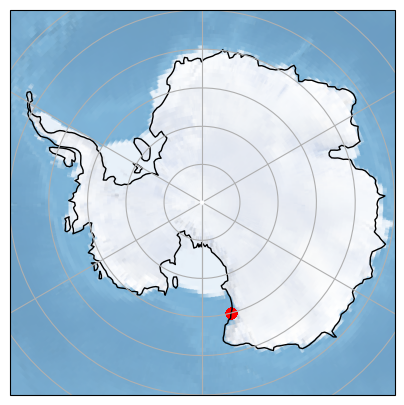

In [19]:
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -65], crs=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
ax.stock_img()
ax.gridlines()
gps_gdf.plot(ax=ax, markersize=50, color='red', transform=ccrs.PlateCarree(), aspect=None);

### Calibrate with glider mean environmental data

We'll use the environmental data (temperature, salinity and pressure) found in the external glider file to calibrate the backscatter data and create a volume backscattering strength (`Sv`) dataset.

In [20]:
# Grab and average environmental parameters
env_params_means = {}
for env_var in ["temperature", "salinity", "pressure"]:
    env_params_means[env_var] = float(glider_ds[env_var].mean().values)
env_params_means

{'temperature': -1.020638108253479,
 'salinity': 34.53363037109375,
 'pressure': 38.693416595458984}

In [21]:
# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed, env_params=env_params_means)
ds_Sv

<xarray.Dataset> Size: 88MB
Dimensions:                (channel: 3, ping_time: 920, range_sample: 1999,
                            filenames: 1)
Coordinates:
  * channel                (channel) <U11 132B '59006-38-1' ... '59006-200-3'
  * ping_time              (ping_time) datetime64[ns] 7kB 2018-01-11T07:44:40...
  * range_sample           (range_sample) int64 16kB 0 1 2 3 ... 1996 1997 1998
  * filenames              (filenames) int64 8B 0
Data variables: (12/18)
    Sv                     (channel, ping_time, range_sample) float64 44MB -1...
    echo_range             (channel, ping_time, range_sample) float64 44MB 0....
    frequency_nominal      (channel) float64 24B 3.8e+04 1.25e+05 2e+05
    sound_speed            float64 8B 1.444e+03
    sound_absorption       (channel) float64 24B 0.009111 0.03012 0.04501
    temperature            float64 8B -1.021
    ...                     ...
    TVR                    (channel) float64 24B 156.2 168.5 165.9
    VTX0                   (channel) float64 24B 157.0 146.7 133.3
    equivalent_beam_angle  (channel) float64 24B 0.1306 0.01071 0.01071
    Sv_offset              (channel) float64 24B 0.7 0.3 0.3
    source_filenames       (filenames) <U37 148B 'example_data/Glider_AZFP/18...
    water_level            float64 8B nan
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.8.2.dev207+g0a7dbd6
    processing_time:              2024-07-31T23:43:46Z
    processing_function:          calibrate.compute_Sv

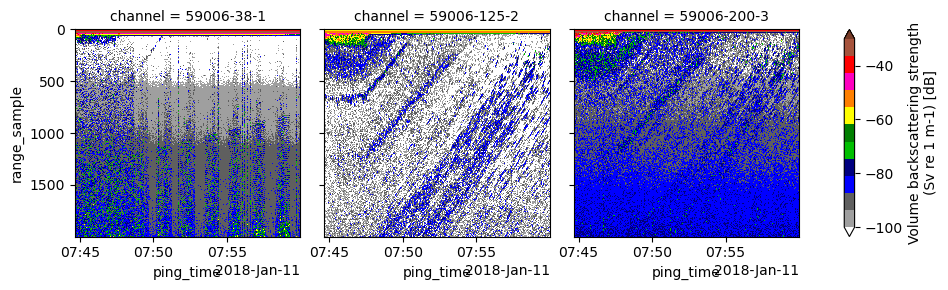

In [22]:
# Plot Sv
ds_Sv["Sv"].plot(col="channel", yincrease=False, y="range_sample", vmin=-100, vmax=-30, cmap="ep.ek500")

Note that the 'top' portion of the Echograms have extremely high Sv values. Let's drop these since they are most likely some form of surface noise:

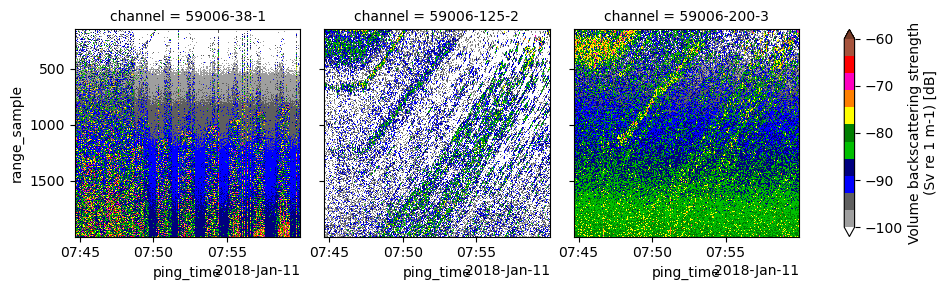

In [23]:
# Select and plot Sv:
ds_Sv = ds_Sv.isel(range_sample=slice(150,None))
ds_Sv["Sv"].plot(col="channel", yincrease=False, y="range_sample", vmin=-100, vmax=-60, cmap="ep.ek500")

### Remove Background Noise

In [24]:
# Remove background noise
ds_Sv = ep.clean.remove_background_noise(
    ds_Sv,
    ping_num=5,
    range_sample_num=5,
    # Threshold value from https://github.com/a-sheehan/Echopype-Processing-Pipeline-for-AZFP-and-Glider-Data/blob/main/Sheehan_azfp_forloop.ipynb
    SNR_threshold="2.0dB",
)

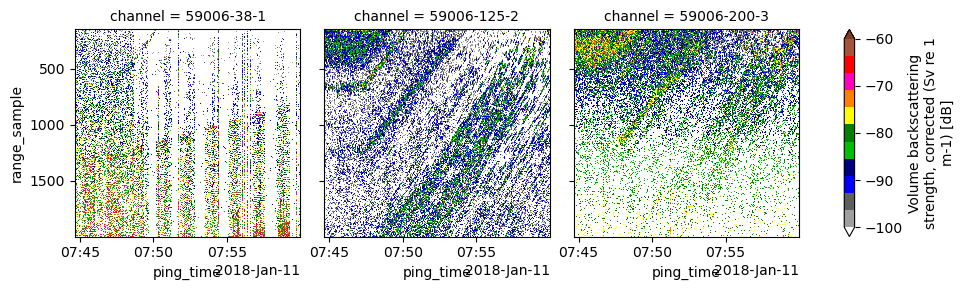

In [25]:
# Plot corrected Sv
ds_Sv["Sv_corrected"].plot(col="channel", yincrease=False, y="range_sample", vmin=-100, vmax=-60, cmap="ep.ek500")

However, since the glider is going downwards, displaying the Echogram as such is not correct since it does not display the backscatter at its respective depth.

At the Sv stage of processing, we can use Range Sample as a quasi-depth proxy when plotting, since it is a 1D variable and can be shown on the axis.

The Sv dataset object also contains the Echo Range variable which describes the physical range that the backscatter data has come from:

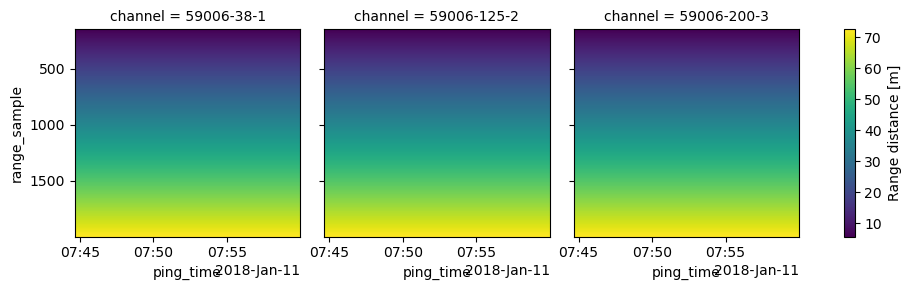

In [26]:
# Plot echo range
ds_Sv["echo_range"].plot(col="channel", y="range_sample", yincrease=False)

In [27]:
# Show echo range dimensions
ds_Sv["echo_range"].dims

('channel', 'ping_time', 'range_sample')

This is a 3D array, with the same dimensions as the Sv array. In this case, the Echo Range is equal per-channel and per-ping; however, this is not always the case and so we have to construct the Echo Range variable as a 3D array.

It is evident though that the Echo Range variable does not display this downward movement behavior that we expect of the glider. With Echopype, we can use the Echo Range variable and external parameters to compute a depth array that captures this downward glider behavior.

### Add Depth

We can use external parameters from the `glider_ds` to compute depth. 

We must first convert the glider dataset's pitch and roll, which are in radians, into tilt, which is in degrees.

In [35]:
# Correct pitch based on the processing from:
# https://github.com/a-sheehan/Echopype-Processing-Pipeline-for-AZFP-and-Glider-Data/blob/main/Sheehan_azfp_forloop.ipynb
correct_pitch = glider_ds["m_pitch"].where(
    (glider_ds["m_pitch"]*180/np.pi < -15) & (glider_ds["m_pitch"]*180/np.pi > -30),
    other=np.nan
)

# Convert pitch and roll from radians to degrees
pitch = np.rad2deg(correct_pitch)
roll = np.rad2deg(glider_ds["m_roll"])

# Compute tilt in degrees from pitch roll rotations
yaw = np.zeros_like(pitch.values)
yaw_pitch_roll_euler_angles_stack = np.column_stack([yaw, pitch.values, roll.values])
yaw_rot_pitch_roll = R.from_euler("ZYX", yaw_pitch_roll_euler_angles_stack, degrees=True)
glider_tilt = yaw_rot_pitch_roll.as_matrix()[:, -1, -1]
glider_tilt = xr.DataArray(
    glider_tilt, dims="time", coords={"time": glider_ds["time"]}
)
glider_tilt_in_degrees = np.rad2deg(np.arccos(glider_tilt))
glider_tilt_in_degrees.attrs = {
    "long_name": "Tilt",
    "units": "Degrees"
}

Plotting glider tilt:

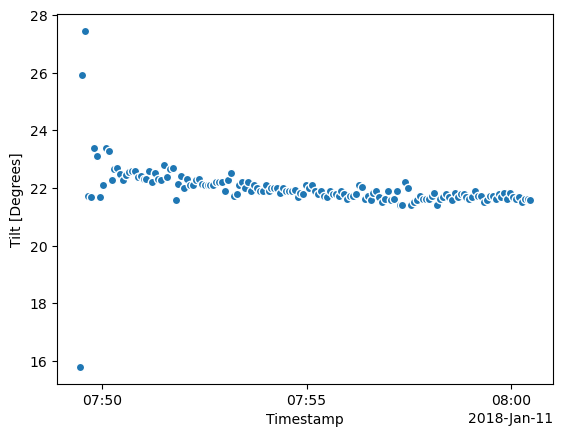

In [36]:
# Plot glider tilt
glider_tilt_in_degrees.plot.scatter()

Plotting glider specified depth:

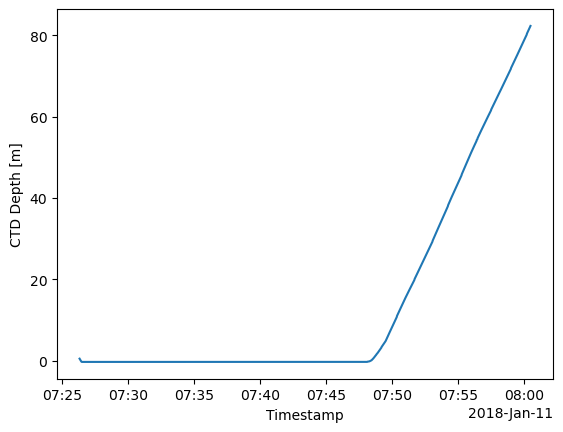

In [37]:
# Plot glider depth
glider_ds["depth"].dropna(dim="time").plot.line()

We use both angular and vertical offset information alongside Echo Range in `ep.consolidate.add_depth` to correctly compute the depth that each backscatter data point corresponds to:

In [38]:
# Add depth to Sv dataset incorporating Glider depth and tilt data
ds_Sv = ep.consolidate.add_depth(
    ds_Sv,
    depth_offset=glider_ds["depth"].dropna("time"),
    tilt=glider_tilt_in_degrees.dropna("time"),
)

Plot the depth array:

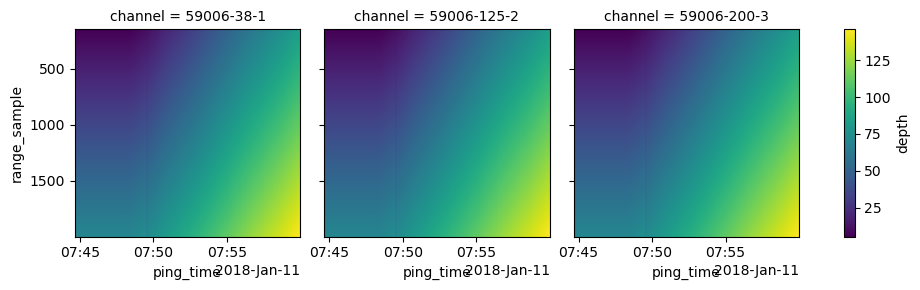

In [39]:
# Plot the depth array
ds_Sv["depth"].plot(col="channel", y="range_sample", yincrease=False)

Plot the 125 kHz channel of the Sv corrected dataset using depth as a 2D coordinate:

/tmp/ipykernel_16702/2507293261.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh = plt.pcolormesh(


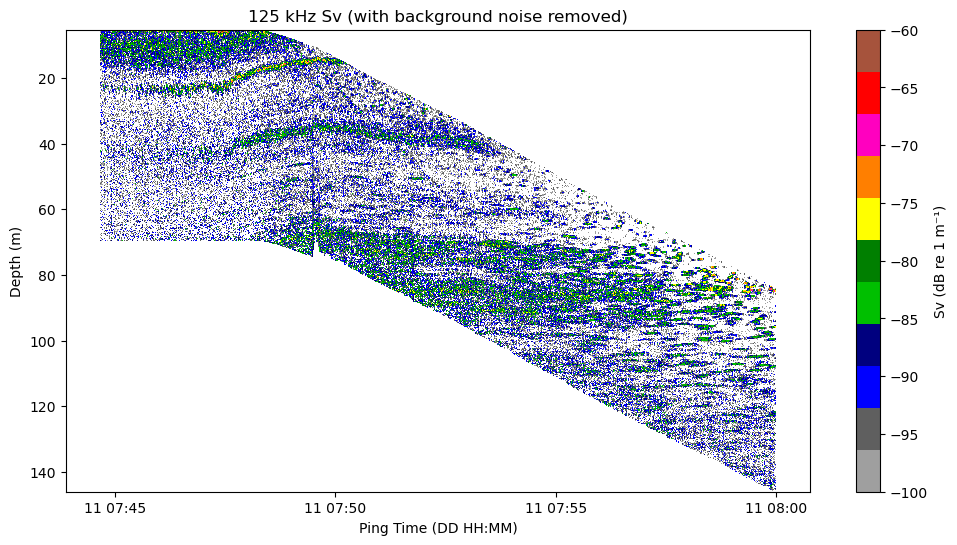

In [73]:
# Create a single subplot
fig, ax = plt.subplots(1,1,figsize=(12,6))

# Plot 38 kHz Sv corrected channel as a 2D mesh with depth and ping time coords
pcolormesh = plt.pcolormesh(
    ds_Sv["ping_time"].broadcast_like(ds_Sv["range_sample"]).values.T,
    ds_Sv["depth"].sel(channel="59006-125-2").values, 
    ds_Sv["Sv_corrected"].sel(channel="59006-125-2").values,
    shading='auto',
    vmin=-100,
    vmax=-60,
    cmap="ep.ek500",
)
plt.gca().invert_yaxis()

# Add title and axis labels
plt.title("125 kHz Sv (with background noise removed)")
plt.xlabel("Ping Time (DD HH:MM)")
plt.ylabel("Depth (m)")

# Add colorbar
plt.colorbar(pcolormesh, label="Sv (dB re 1 m⁻¹)")

# Show plot
plt.show()

### Compute Shoal Mask and Apply on Corrected Sv

Since we have gotten our calibrated backscatter volume data into an easily manipulatable array format, we can use another open-source fisheries acoustics package, [Echopy](https://github.com/open-ocean-sounding/echopy), to process our Sv data further, since the majority of Echopy's masking functions take in 2D numpy arrays.

We can use Echopy's implementation of Echoview's shoal masking algorithm to extract the Zooplankton shoals that we see in the Echogram above. Note that we have to do very minimal wrangling of our data to get it into a format that both Echopy and Xarray will like.

In [55]:
# Use Echopy's Echoview Shoal Mask function on the corrected Sv
shoal_mask_da = xr.DataArray(
    data = echopy.processing.mask_shoals.echoview(
        ds_Sv["Sv_corrected"].sel(channel="59006-125-2").values.T,
        idim=np.arange(len(ds_Sv["range_sample"])+1),
        jdim=np.arange(len(ds_Sv["ping_time"])+1),
        thr=-90,
    )[0].T,
    dims=["ping_time", "range_sample"],
    coords={
        "ping_time": ds_Sv["ping_time"],
        "range_sample": ds_Sv["range_sample"],
    }
)

**Future Plans**: We currently have several noise and attenuated signal masking functions from Echopy already within Echopype that are 'scalable' via Dask. We plan to integrate more Echopy masking functions into the Echopype system, including `echopy.processing.mask_shoals.echoview`, in the future.

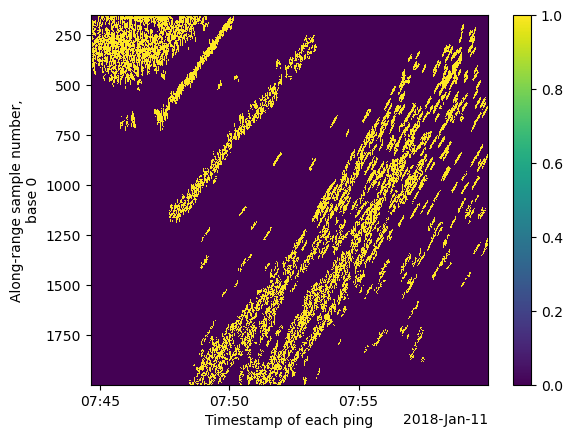

In [56]:
# Plot the Shoal Mask
shoal_mask_da.plot(yincrease=False, y="range_sample")

In [57]:
# Apply Shoal Mask on the corrected Sv
ds_shoal_masked_Sv = echopype.mask.apply_mask(ds_Sv, shoal_mask_da, var_name="Sv_corrected")

Plot the 125 kHz channel of the shoal masked Sv dataset using depth as a 2D coordinate:

/tmp/ipykernel_16702/12736882.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh = plt.pcolormesh(


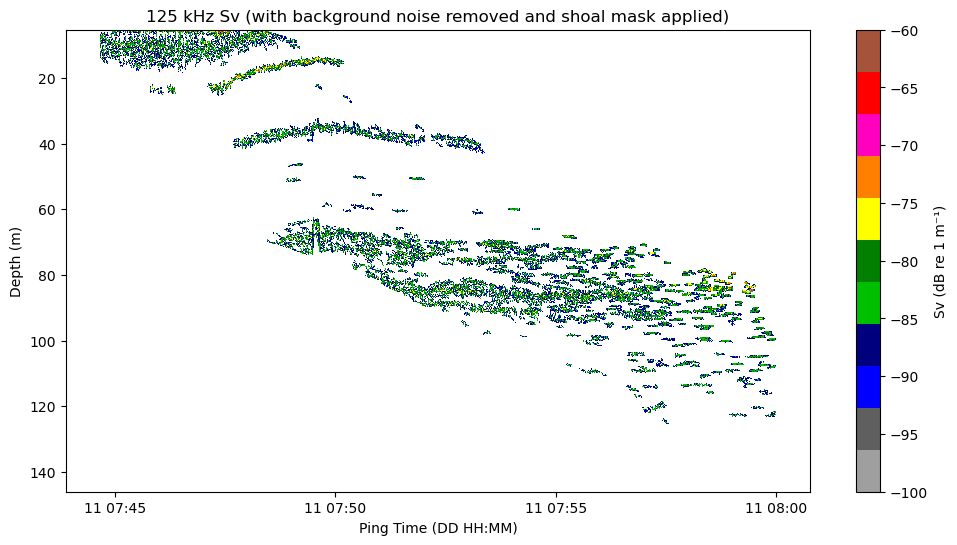

In [72]:
# Create a single subplot
fig, ax = plt.subplots(1,1,figsize=(12,6))

# Plot shoal masked 38 kHz Sv channel as a 2D mesh with depth and ping time coords
pcolormesh = plt.pcolormesh(
    ds_shoal_masked_Sv["ping_time"].broadcast_like(ds_shoal_masked_Sv["range_sample"]).values.T,
    ds_shoal_masked_Sv["depth"].sel(channel="59006-125-2").values, 
    ds_shoal_masked_Sv["Sv_corrected"].sel(channel="59006-125-2").values,
    shading='auto',
    vmin=-100,
    vmax=-60,
    cmap="ep.ek500",
)
plt.gca().invert_yaxis()

# Add title and axis labels
plt.title("125 kHz Sv (with background noise removed and shoal mask applied)")
plt.xlabel("Ping Time (DD HH:MM)")
plt.ylabel("Depth (m)")

# Add colorbar
plt.colorbar(pcolormesh, label="Sv (dB re 1 m⁻¹)")

# Show plot
plt.show()

### Compute and Plot Zooplankton-specific Mean Volume Backscattering Strength (MVBS)

`ep.commongrid.compute_MVBS` requires that the to-be-regridded Sv data is named `Sv` in the passed in dataset. We want to regrid the `Sv_corrected` data since it has noise removed and shoal mask applied, so we must set it as `Sv`:

In [59]:
# Set Sv_corrected as Sv
ds_shoal_masked_Sv["Sv"] = ds_shoal_masked_Sv["Sv_corrected"]

Compute MVBS of the Shoal Masked Sv:

In [60]:
# Compute shoal masked MVBS
ds_shoal_masked_MVBS = ep.commongrid.compute_MVBS(ds_shoal_masked_Sv, range_bin="1m", ping_time_bin="5s", range_var="depth")

Plot the 125 kHz channel of the shoal masked MVBS dataset using depth as a 2D coordinate:

/tmp/ipykernel_16702/211740337.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcolormesh = plt.pcolormesh(


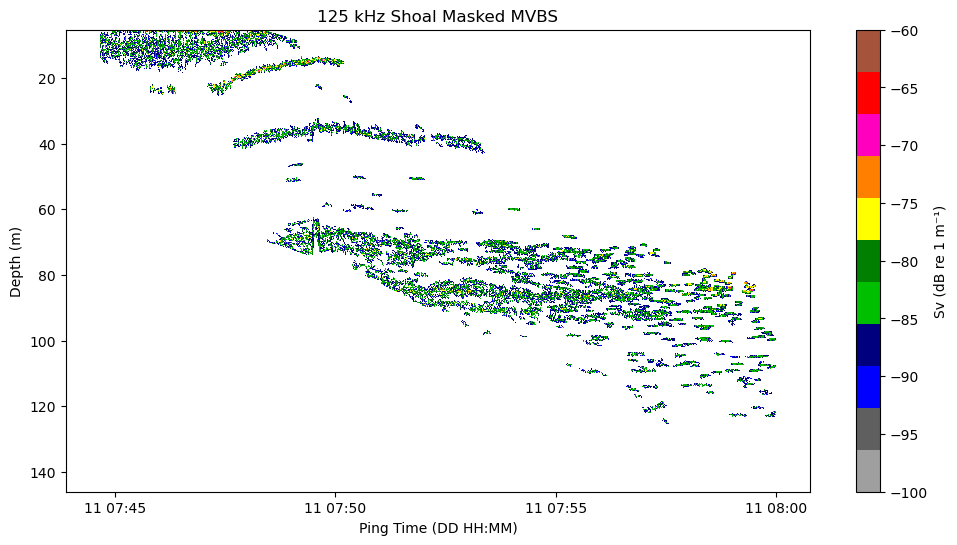

In [70]:
# Create a single subplot
fig, ax = plt.subplots(1,1,figsize=(12,6))

# Plot shoal masked 38 kHz MVBS channel as a 2D mesh with depth and ping time coords
pcolormesh = plt.pcolormesh(
    ds_shoal_masked_Sv["ping_time"].broadcast_like(ds_shoal_masked_Sv["range_sample"]).values.T,
    ds_shoal_masked_Sv["depth"].sel(channel="59006-125-2").values, 
    ds_shoal_masked_Sv["Sv_corrected"].sel(channel="59006-125-2").values,
    shading='auto',
    vmin=-100,
    vmax=-60,
    cmap="ep.ek500",
)
plt.gca().invert_yaxis()

# Add title and axis labels
plt.title("125 kHz Shoal Masked MVBS")
plt.xlabel("Ping Time (DD HH:MM)")
plt.ylabel("Depth (m)")

# Add colorbar
plt.colorbar(pcolormesh, label="Sv (dB re 1 m⁻¹)")

# Show plot
plt.show()

## Package versions

In [62]:
import datetime
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.8.2.dev207+g0a7dbd6, xarray: 2024.6.0, geopandas: 1.0.1

2024-07-31 23:54:08.133450 +00:00
